<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 4: Modelling of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

###### References

1. https://www.kaggle.com/code/kkhandekar/an-introduction-to-pycaret/notebook.
2. https://towardsdatascience.com/5-things-you-dont-know-about-pycaret-528db0436eec
3. https://www.dataquest.io/blog/understanding-regression-error-metrics/ 
4. https://www.analyticsvidhya.com/blog/2021/07/automl-using-pycaret-with-a-regression-use-case/
5. https://www.datacamp.com/community/tutorials/guide-for-automating-ml-workflows-using-pycaret
6. https://pycaret.readthedocs.io/en/latest/api/regression.html
7. http://www.pycaret.org/tutorials/html/REG102.html
8. https://githubhelp.com/ray-project/tune-sklearn

#### Libraries

In [1]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


###### Declare some global variables

In [2]:
#Receive Data
#dir_name = r'C:\Users\kswaminathan\OneDrive\01_KannaLibrary\15_Analogs'
dir_name = r'C:\Users\mkumar\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [3]:
skiprows = 0
#Means read in the ',' as thousand seperator. Also drops all columns which are unnamed.
df = pd.read_excel("dfssoil.xlsx", thousands=',', skiprows = skiprows)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df.head()

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),118_Structural flank dip (average) (deg.),149_Reservoir period,...,161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),307_Recovery factor (ultimate oil) (%),EORIOR
0,AFRICA,ABU GHARADIG,140.0,ONSHORE,232.0,4500.000000,GAS DRIVE,9350.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.10,21.0,140.00,40.5,13.810000,850.0,166.0,19.0,2
1,AFRICA,ABU GHARADIG,140.0,ONSHORE,250.0,4600.000000,GAS DRIVE,9650.0,15.0,CRETACEOUS,...,JIGSAW-PUZZLE,0.07,16.0,140.00,40.0,4.740000,800.0,214.0,14.0,2
2,MIDDLE EAST,ZAGROS,0.0,ONSHORE,190.0,4452.278385,AQUIFER DRIVE,7500.0,20.0,NEOGENE/PALEOGENE,...,LAYER-CAKE,0.36,19.0,385.00,32.6,0.580000,950.0,57300.0,44.3,3
3,MIDDLE EAST,SOUTH OMAN SALT,62.0,ONSHORE,212.0,11600.000000,GAS DRIVE,12140.0,10.0,CAMBRIAN/PROTEROZOIC,...,LAYER-CAKE,0.68,17.0,0.01,48.0,0.135469,410.0,1321.0,7.0,4
4,EUROPE,NORTH SEA CENTRAL,0.0,OFFSHORE,172.0,2850.000000,GAS DRIVE,6102.0,1.5,PALEOGENE,...,TANK LIKE,0.80,35.0,3000.00,19.5,7.000000,246.0,1000.0,44.0,7


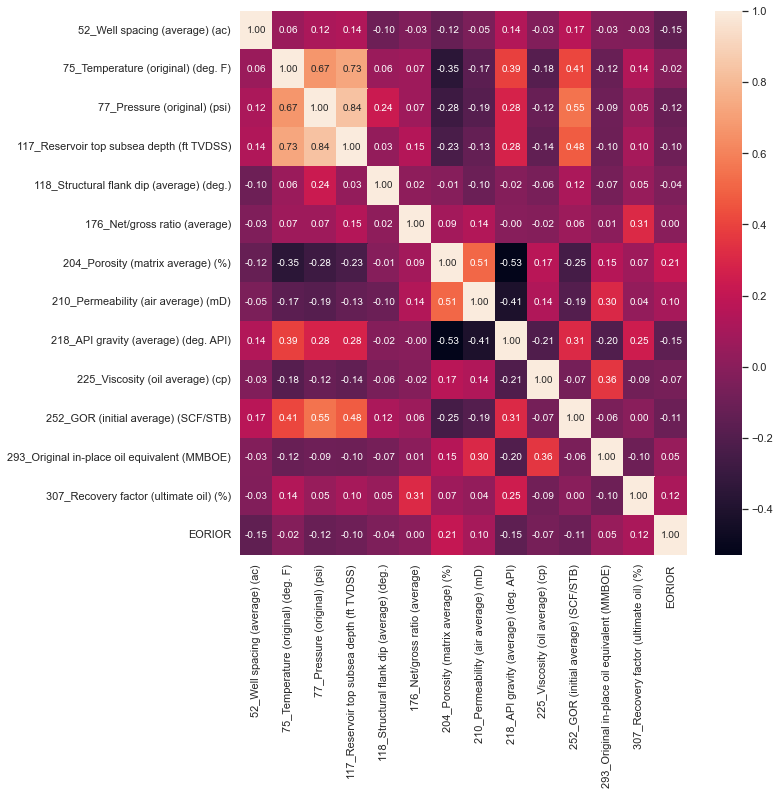

In [4]:
# Plot as Heat map to check for highly correlated variables
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f")

In observing the heat map above, I define highly correlated variables as having collinearity coeeficients of > 0.7. Therefore,

1. 75_ Temperature is highly correlatable to 117_Reservoir top subsea depth
2. 77_Pressure is highly correlatable to  117_Reservoir top subsea depth

As high collinear variables do not add any additional information when it comes to predictive modelling, I will drop "117_Reservoir top subsea depth" and recreate the heat map to check for correlation.

Note that dropping the variables makes sense, as reservoir top subsea depth should be physically linked to pressure and temperature in a reservoir

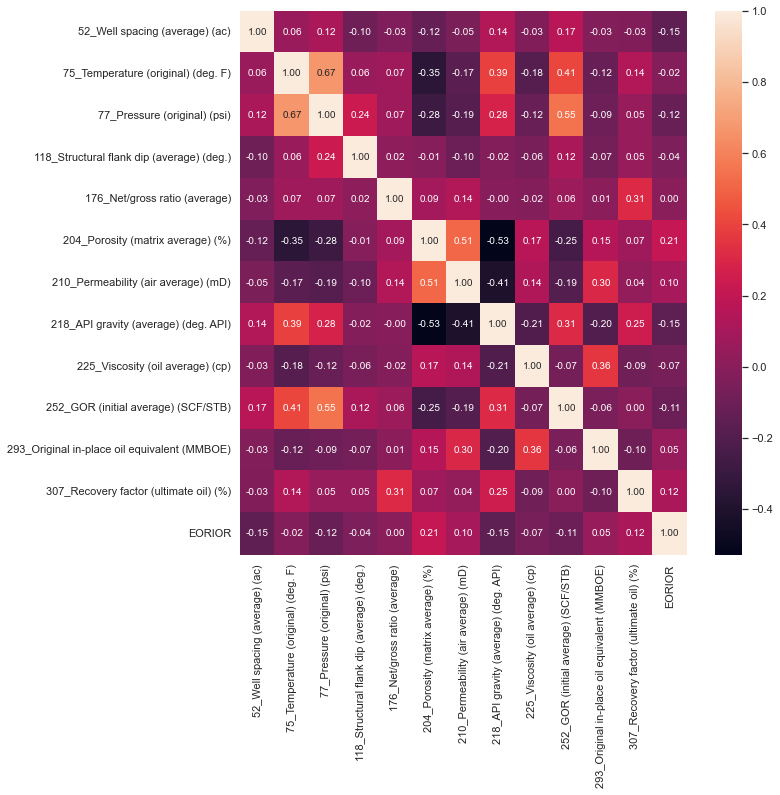

In [5]:
df_drop = df.drop(['117_Reservoir top subsea depth (ft TVDSS)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Drop Structural Flank Dip - does not make much difference to the results and is a difficult input to find for fields

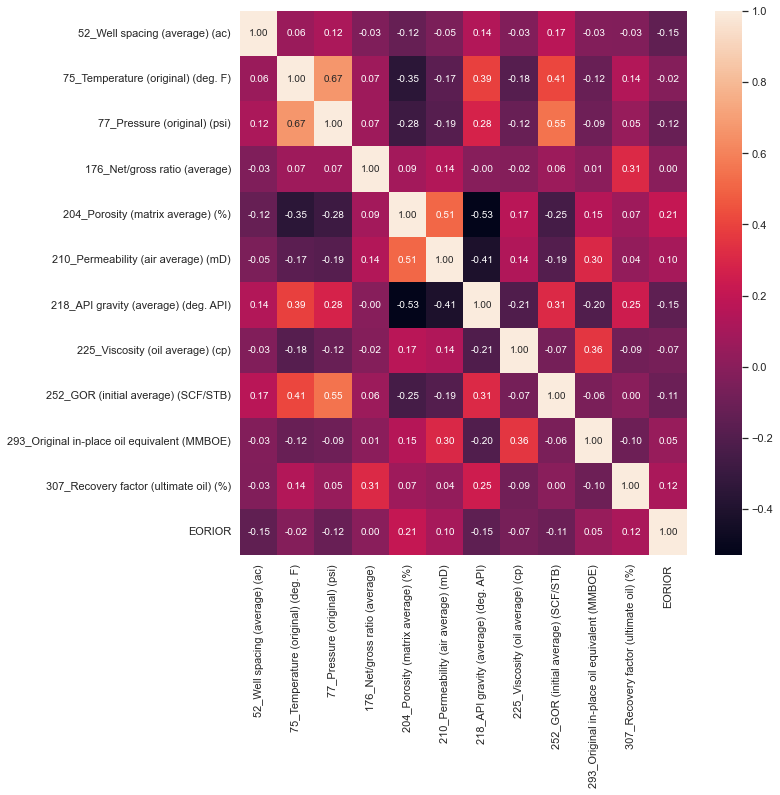

In [6]:
df_drop = df_drop.drop(['118_Structural flank dip (average) (deg.)',
                  ], axis = 1)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(df_drop.corr(), annot=True, fmt=".2f")

##### Convert EORIOR to float - to ensure it is a numerical feature

In [7]:
df_drop['EORIOR'] = df_drop['EORIOR'].astype(float)

# Confirm properties of final dataframe
print(len(df_drop))
print(df_drop.info())
print(df_drop.describe(include='all'))
print(df_drop.columns.values)

436
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   10_Region                                     436 non-null    object 
 1   11_Basin name                                 436 non-null    object 
 2   52_Well spacing (average) (ac)                436 non-null    float64
 3   72_Onshore or offshore                        436 non-null    object 
 4   75_Temperature (original) (deg. F)            436 non-null    float64
 5   77_Pressure (original) (psi)                  436 non-null    float64
 6   82_Drive mechanism (main)                     436 non-null    object 
 7   149_Reservoir period                          436 non-null    object 
 8   153_Depositional system (main)                436 non-null    object 
 9   161_Reservoir architecture (main)             436 non-null   

Final Data set has 436 rows and 19 columns.

## 1. Pycaret Implementation

Pycaret will be used in the machine learning portion. Pycaret is a low-code machine learning library in Python that automates machine learning workflows. One of its key benefits is its ability to run a large number of differnt machine learning algorithms, but with only a few lines of code

In [8]:
from pycaret.regression import *

#Create a copy
model_df = df_drop.copy()
target = '307_Recovery factor (ultimate oil) (%)'

# no resampling
clf_none = setup(
            data=model_df,
            target=target,
            session_id=42,
            normalize=True,
            ignore_low_variance=True,
            train_size=0.7)

,Description,Value
0,session_id,42
1,Target,307_Recovery factor (ultimate oil) (%)
2,Original Data,"(436, 19)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(305, 154)"


In [9]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.8658,125.0359,11.1468,0.4177,0.3442,0.3201,0.7490
rf,Random Forest Regressor,9.3928,135.1021,11.6123,0.3694,0.3576,0.3371,0.0510
gbr,Gradient Boosting Regressor,9.6589,141.3729,11.8708,0.3378,0.3638,0.3435,0.0180
xgboost,Extreme Gradient Boosting,9.4470,144.1076,11.9662,0.3202,0.3627,0.3234,0.1160
ada,AdaBoost Regressor,9.8921,146.6899,12.0955,0.3127,0.3761,0.3683,0.0170
lightgbm,Light Gradient Boosting Machine,9.9070,147.3030,12.1090,0.3106,0.3633,0.3463,0.0290
et,Extra Trees Regressor,10.3469,163.1655,12.7459,0.2390,0.3918,0.3740,0.0500
br,Bayesian Ridge,10.7803,173.3774,13.1362,0.1943,0.4022,0.3977,0.0060
knn,K Neighbors Regressor,10.8706,176.8327,13.2565,0.1772,0.4131,0.4080,0.0070
lasso,Lasso Regression,11.1737,184.7241,13.5774,0.1399,0.4180,0.4212,0.1790


In [10]:
top3_fold_5 = compare_models(include=['rf', 'gbr', 'catboost'], fold = 5, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,9.0604,129.4306,11.3588,0.4025,0.3551,0.3319,0.6340
rf,Random Forest Regressor,9.2614,133.3879,11.5406,0.3836,0.3562,0.3344,0.0620
gbr,Gradient Boosting Regressor,9.7232,142.6388,11.9330,0.3415,0.3681,0.3474,0.0280


In [11]:
top3 = compare_models(include=['rf', 'gbr', 'catboost'], fold = 10, sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,8.8658,125.0359,11.1468,0.4177,0.3442,0.3201,0.7330
rf,Random Forest Regressor,9.3928,135.1021,11.6123,0.3694,0.3576,0.3371,0.0540
gbr,Gradient Boosting Regressor,9.6589,141.3729,11.8708,0.3378,0.3638,0.3435,0.0190


There is a performance improvement in going from 5 folds to 10 folds for catboost and gbr. However, for rf, 5 folds performs better. However, the improvement is marginal so for simplicity, and to keep computation time reasonable, folds is kept at 10.

## 2. Plot each Model and Check Features

##### Category Boosting (CatBoost)

In [12]:
cb = create_model('catboost')
cb_results = pull()
#print(cb_results)

import pandas as pd
cb_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(cb.feature_importances_)}).sort_values(by='Value', ascending=False)
#print(cb_feature_imp)
cb_feature_imp.to_csv('Featue_importance_CATBOOST.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.7774,143.7698,11.9904,0.3290,0.4423,0.4321
1,7.1289,96.1058,9.8034,0.5254,0.2974,0.2469
2,9.7137,139.7118,11.8200,0.3389,0.4119,0.4119
3,9.4459,162.8558,12.7615,0.3031,0.3707,0.3206
4,8.1459,113.1566,10.6375,0.4653,0.2931,0.2522
5,8.5145,101.7543,10.0873,0.5682,0.3716,0.3609
6,8.7495,122.0168,11.0461,0.4718,0.2692,0.2302
7,8.7297,110.2910,10.5020,0.3684,0.3032,0.2768
8,9.4621,121.1993,11.0091,0.4277,0.3276,0.3173
9,9.9906,139.4974,11.8109,0.3789,0.3553,0.3518


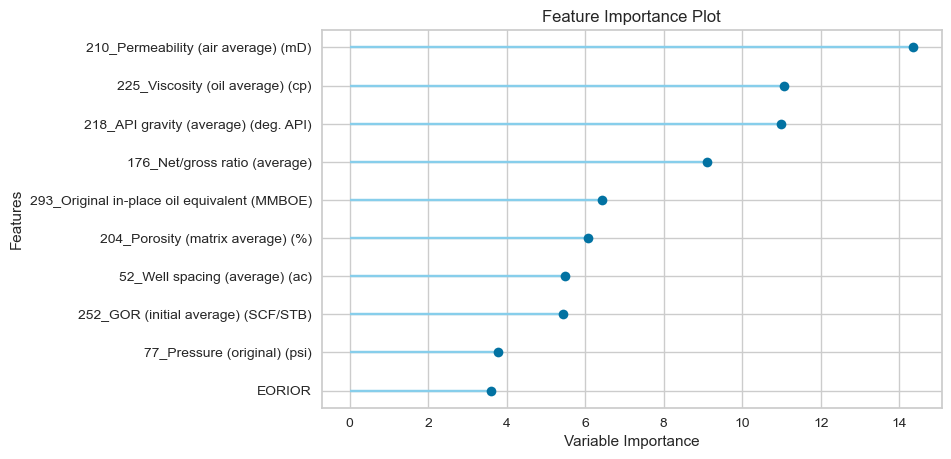

In [13]:
# Given the sheer number of variables, will only plot the first 10
# 'feature_all' will plot everything
plot_model(cb, plot = 'feature')

##### Random Forest (RFR)

In [14]:
rfr = create_model('rf')
rfr_results = pull()

import pandas as pd
rfr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(rfr.feature_importances_)}).sort_values(by='Value', ascending=False)
rfr_feature_imp.to_csv('Feature_importance_RFR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.1114,135.2387,11.6292,0.3689,0.4158,0.3989
1,9.0111,130.6803,11.4316,0.3546,0.3296,0.2945
2,9.6606,141.5488,11.8974,0.3302,0.4234,0.4284
3,9.1564,140.8654,11.8687,0.3972,0.3636,0.3357
4,8.8310,130.1396,11.4079,0.3850,0.3148,0.2785
5,9.7976,124.7850,11.1707,0.4705,0.3944,0.4059
6,9.0411,132.9739,11.5314,0.4243,0.2734,0.2265
7,8.6972,114.5386,10.7023,0.3441,0.3180,0.2870
8,10.9339,162.7236,12.7563,0.2316,0.3677,0.3542
9,9.6878,137.5266,11.7272,0.3877,0.3748,0.3617


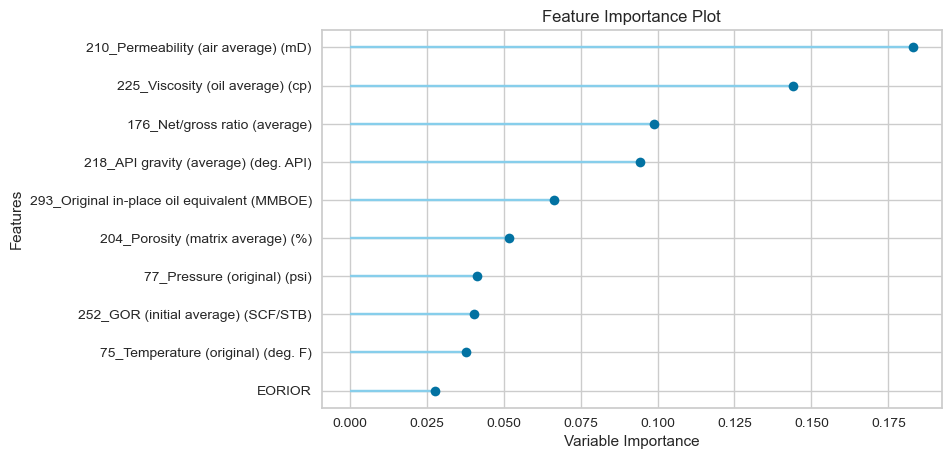

In [15]:
plot_model(rfr, plot = 'feature')

##### Gradient Boosting (GBR)

In [16]:
gbr = create_model('gbr')
gbr_results = pull()
#print(gbr_results)

import pandas as pd
gbr_feature_imp = pd.DataFrame({'Feature': get_config('X_train').columns, 'Value' : abs(gbr.feature_importances_)}).sort_values(by='Value', ascending=False)
gbr_feature_imp.to_csv('Feature_importance_GBR.csv')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.5535,151.0181,12.2889,0.2952,0.4355,0.4276
1,8.7608,115.4462,10.7446,0.4299,0.3173,0.2912
2,9.6868,152.7776,12.3603,0.2771,0.4282,0.4189
3,8.5895,148.1668,12.1724,0.3659,0.3530,0.2850
4,8.6990,126.0041,11.2252,0.4045,0.3112,0.2778
5,9.4480,121.1348,11.0061,0.4860,0.3828,0.3834
6,9.8464,130.8128,11.4373,0.4337,0.2900,0.2636
7,10.3484,145.2470,12.0518,0.1682,0.3548,0.3374
8,11.3218,161.8410,12.7217,0.2358,0.3671,0.3651
9,10.3350,161.2802,12.6996,0.2819,0.3983,0.3846


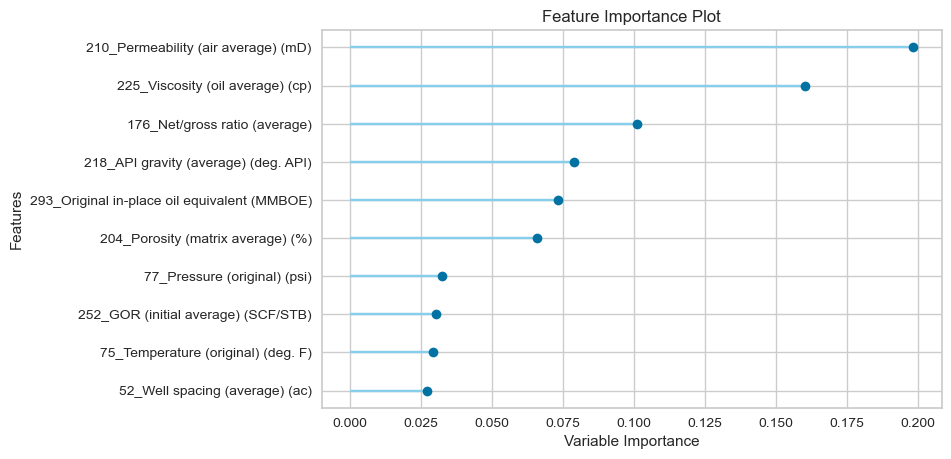

In [17]:
plot_model(gbr, plot = 'feature')

## 3a. Testing for Optimisation - Not necessary to run
-----------------------------------------------------------------------------------

One of the important parameters in the hyperparameters is the number of iterations over which the K fold cross validation is done. 

2 checks are done for this. The first scenario is over the range(0, 1000, 50). The optimisation ran overnight and showed that the ML algorithm did not see much improvement past 50.

In [ ]:
elapsed = []
MAE_mean_iter = []
MSE_mean_iter = []
RMSE_mean_iter = []

# The output from the (0, 1000, 50) is saved; there is no need to run this again. 
# Line has been modified just so the code can run.
for i in range(0, 51, 50):
    start = time.time()
    if i == 0:
        i += 1    
    tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
    #print(tuned_cb)
    MAE_mean_iter.append(pull()['MAE']['Mean'])
    MSE_mean_iter.append(pull()['MSE']['Mean'])
    RMSE_mean_iter.append(pull()['RMSE']['Mean'])
    elapsed.append((time.time() - start))

MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
MAE_Mean.index.name = 'Elapsed Time'

MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
MSE_Mean.index.name = 'Elapsed Time'

RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
RMSE_Mean.index.name = 'Elapsed Time'

res_50_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

print(res_50_iter)

In [ ]:
b = sns.lineplot(data=res_50_iter)
b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
b.set_xlabel("Elapsed Time",fontsize=20)
b.set_ylabel("Error",fontsize=20)
#b.set_yscale('log')
b.tick_params(labelsize=18)

In [ ]:
#res.to_csv('Run_Catboost_1000_Itr.csv')

In [ ]:
elapsed = []
MAE_mean_iter = []
MSE_mean_iter = []
RMSE_mean_iter = []

# This was run at (1, 51, 1) to get increments of 1
# Right now, this is changed to (1, 51, 50) to allow the code to run efficiently
for i in range(1, 51, 50):
    start = time.time()
    tuned_cb = tune_model(cb, optimize = 'MSE', n_iter = i)
    MAE_mean_iter.append(pull()['MAE']['Mean'])
    MSE_mean_iter.append(pull()['MSE']['Mean'])
    RMSE_mean_iter.append(pull()['RMSE']['Mean'])
    elapsed.append((time.time() - start))

MAE_Mean = pd.DataFrame(MAE_mean_iter, index = elapsed, columns=['MAE Mean Error'])
MAE_Mean.index.name = 'Elapsed Time'

MSE_Mean = pd.DataFrame(MSE_mean_iter, index = elapsed, columns=['MSE Mean Error']) 
MSE_Mean.index.name = 'Elapsed Time'

RMSE_Mean = pd.DataFrame(RMSE_mean_iter, index = elapsed, columns=['RMSE Mean Error'])
RMSE_Mean.index.name = 'Elapsed Time'

res_1_iter = pd.concat([MAE_Mean, MSE_Mean, RMSE_Mean], axis=1)

print(res_1_iter)

res_1_iter.to_csv('Run_Catboost_50_Itr.csv')

In [ ]:
b = sns.lineplot(data=res_1_iter)
b.axes.set_title("Error as function of Elapsed Time",fontsize=20)
b.set_xlabel("Elapsed Time",fontsize=20)
b.set_ylabel("Error",fontsize=20)
#b.set_yscale('log')
b.tick_params(labelsize=18)

In [ ]:
tuned_cb3 = tune_model(cb, optimize = 'RMSE', n_iter = 10)

In [ ]:
plot_model(tuned_cb3, plot = 'parameter')

##### Gradient Boosting Regression

In [ ]:
gbr = create_model('gbr')
print(gbr)

In [ ]:
tuned_gbr = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
print(tuned_gbr)

In [ ]:
#tuned_gbr1 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="hyperopt", optimize="RMSE", n_iter=50)
#print(tuned_gbr1)

In [ ]:
#tuned_gbr4 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="optuna", optimize="RMSE", n_iter=50)
#print(tuned_gbr4)

In [ ]:
#tuned_gbr5 = tune_model(gbr, search_library = "tune-sklearn", search_algorithm="bayesian", optimize="RMSE", n_iter=50)
#print(tuned_gbr5)

----------------------------------------------------------------------------------------------------------------------------

## 3. Optimisation

### a. Tune the Model

The earlier experiments allow one to determine which model performs efficiently, and the tuning needed to arrive at the answer. Here, we will create the 3 specific models , which we will than blend, and than finally produce a "tuned" blended model based on earlier optimised parameters

from pycaret.distributions import UniformDistribution, CategoricalDistribution

catboost_param_dists = {
    'iterations': CategoricalDistribution([500,100,300]),
    'colsample_bylevel': UniformDistribution(0.5, 1.0),
    'random_strength': CategoricalDistribution([0,0.1,0.2,1,10]),
    'max_depth' : CategoricalDistribution([5,6,7,8,9])
}

In [18]:
tuned_models = []

cb = create_model('catboost', fold = 10)
cb_opt = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                search_library = "optuna", 
                #custom_grid = catboost_param_dists ,
                #early_stopping = "asha",
                #early_stopping_max_iters = 10,
                #return_tuner = False ,                
               )

cb = create_model('catboost', fold = 10)
cb_hyp = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                #search_library = "optuna", 
                search_library = "tune-sklearn", 
                search_algorithm="hyperopt",
                #custom_grid = catboost_param_dists ,
                #early_stopping = "asha",
                #early_stopping_max_iters = 10,
                #return_tuner = False ,                
               )

cb = create_model('catboost', fold = 10)
cb_ran = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                #search_library = "optuna", 
                #search_library = "tune-sklearn", 
                #search_algorithm="bayesian",
                #custom_grid = catboost_param_dists ,
                #early_stopping = "asha",
                #early_stopping_max_iters = 10,
                #return_tuner = False ,                
               )


In [19]:
cb = create_model('catboost', fold = 10)
cb = tune_model(cb, 
                optimize = 'RMSE', 
                n_iter = 50, 
                choose_better = True,
                search_library = "tune-sklearn", 
                search_algorithm="bayesian",              
               )

tuned_models.append(cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.5001,157.0310,12.5312,0.2672,0.4549,0.4617
1,7.4715,94.8912,9.7412,0.5314,0.3042,0.2667
2,10.1222,167.7878,12.9533,0.2061,0.4458,0.4272
3,9.0123,165.7276,12.8735,0.2908,0.3643,0.2954
4,8.5572,120.2550,10.9661,0.4317,0.3093,0.2696
5,8.6874,99.7084,9.9854,0.5769,0.3424,0.3339
6,7.8761,95.2645,9.7604,0.5876,0.2358,0.2051
7,9.5942,133.5850,11.5579,0.2350,0.3243,0.2931
8,10.0258,127.2534,11.2807,0.3991,0.3370,0.3246
9,9.3609,135.7141,11.6496,0.3957,0.3333,0.3125


gbr = create_model('gbr', fold = 10)
gbr = tune_model(gbr, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 search_library = "tune-sklearn", 
                 search_algorithm="Hyperopt")
tuned_models.append(gbr)

gbr = create_model('gbr', fold = 10)
gbr = tune_model(gbr, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 search_library = "tune-sklearn", 
                 search_algorithm="Optuna")
tuned_models.append(gbr)

In [20]:
gbr = create_model('gbr', fold = 10)
gbr = tune_model(gbr, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 search_library = "tune-sklearn", 
                 search_algorithm="bayesian",
                )
tuned_models.append(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.5333,130.1700,11.4092,0.3925,0.4203,0.4047
1,7.8874,107.7828,10.3819,0.4677,0.2978,0.2490
2,9.3228,145.8549,12.0770,0.3098,0.4257,0.4182
3,8.1839,126.1515,11.2317,0.4601,0.3273,0.2739
4,8.0114,113.8136,10.6683,0.4622,0.2939,0.2516
5,8.7134,98.4054,9.9199,0.5824,0.3348,0.3261
6,8.8098,116.5562,10.7961,0.4954,0.2649,0.2308
7,9.1452,124.6215,11.1634,0.2863,0.3223,0.2804
8,10.0713,143.2842,11.9701,0.3234,0.3505,0.3251
9,9.8757,142.9750,11.9572,0.3634,0.3547,0.3394


gbr = create_model('gbr', fold = 10)
gbr = tune_model(gbr, 
                 optimize = 'RMSE', 
                 n_iter = 50, 
                 choose_better = True, 
                 #search_library = "tune-sklearn", 
                 #search_algorithm="bayesian"
                )

In [21]:
rf = create_model('rf', fold = 10)
rf = tune_model(rf, 
                optimize = 'RMSE', 
                n_iter = 10, 
                choose_better = True, 
                search_library = "tune-sklearn", 
                search_algorithm="bayesian")
tuned_models.append(rf)

2022-04-22 20:29:23,353	ERROR trial_runner.py:917 -- Trial _Trainable_d15a8243: Error processing event.
 pid=95960) 2022-04-22 20:29:23,259	ERROR worker.py:430 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::_Inner.__init__() (pid=95960, ip=127.0.0.1, repr=<ray.tune.utils.trainable._Trainable object at 0x000001D8E1878DF0>)


RayActorError: The actor died because of an error raised in its creation task, [36mray::_Inner.__init__()[39m (pid=95960, ip=127.0.0.1, repr=<ray.tune.utils.trainable._Trainable object at 0x000001D8E1878DF0>)
  File "python\ray\_raylet.pyx", line 600, in ray._raylet.execute_task
  File "C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\ray\_private\memory_monitor.py", line 156, in raise_if_low_memory
    raise RayOutOfMemoryError(
ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node WSSP-MUNISH-1 is used (15.29 / 15.83 GB). The top 10 memory consumers are:

PID	MEM	COMMAND
56192	0.39GiB	C:\Users\mkumar\Anaconda3\python.exe -m ipykernel_launcher -f C:\Users\mkumar\AppData\Roaming\jupyte
123516	0.36GiB	C:\Users\mkumar\AppData\Local\Microsoft\Teams\current\Teams.exe --type=renderer --autoplay-policy=no
3148	0.26GiB	C:\WINDOWS\Explorer.EXE
57872	0.24GiB	C:\Users\mkumar\AppData\Local\Microsoft\Teams\current\Teams.exe --type=renderer --autoplay-policy=no
106832	0.23GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
68336	0.23GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
34768	0.22GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
116188	0.22GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
83948	0.21GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
95960	0.21GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r

In addition, up to 0.0 GiB of shared memory is currently being used by the Ray object store.
---
--- Tip: Use the `ray memory` command to list active objects in the cluster.
--- To disable OOM exceptions, set RAY_DISABLE_MEMORY_MONITOR=1.
---


 pid=95960)   File "C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\ray\_private\memory_monitor.py", line 156, in raise_if_low_memory
 pid=95960)     raise RayOutOfMemoryError(
 pid=95960) ray._private.memory_monitor.RayOutOfMemoryError: More than 95% of the memory on node WSSP-MUNISH-1 is used (15.29 / 15.83 GB). The top 10 memory consumers are:
 pid=95960) able
 pid=95960) PID	MEM	COMMAND
 pid=95960) 56192	0.39GiB	C:\Users\mkumar\Anaconda3\python.exe -m ipykernel_launcher -f C:\Users\mkumar\AppData\Roaming\jupyte
 pid=95960) 123516	0.36GiB	C:\Users\mkumar\AppData\Local\Microsoft\Teams\current\Teams.exe --type=renderer --autoplay-policy=no
 pid=95960) 3148	0.26GiB	C:\WINDOWS\Explorer.EXE
 pid=95960) 57872	0.24GiB	C:\Users\mkumar\AppData\Local\Microsoft\Teams\current\Teams.exe --type=renderer --autoplay-policy=no
 pid=95960) 106832	0.23GiB	C:\Users\mkumar\Anaconda3\python.exe C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\r
 pid=95960) 68336	0.23GiB	C:\Use

### b. Ensemble the Model

pycaret.regression.ensemble_model(estimator, method: str = 'Bagging', fold: Optional[Union[int, Any]] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [22]:
prediction_model = []

tuned_bagged_cb = ensemble_model(estimator = cb, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.7811,141.4838,11.8947,0.3397,0.4391,0.4265
1,8.2455,115.4996,10.7471,0.4296,0.3240,0.2862
2,9.6826,142.1518,11.9227,0.3274,0.4153,0.4207
3,9.6472,160.7713,12.6796,0.3120,0.3809,0.3474
4,8.7624,129.6779,11.3876,0.3872,0.3113,0.2756
5,9.1230,108.5100,10.4168,0.5395,0.3842,0.3869
6,9.3153,126.2738,11.2372,0.4533,0.2705,0.2430
7,9.1828,114.4631,10.6987,0.3445,0.3140,0.2953
8,9.5074,122.1987,11.0544,0.4230,0.3255,0.3165
9,9.5870,129.3693,11.3741,0.4240,0.3744,0.3713


In [23]:
tuned_boosted_cb = ensemble_model(estimator = cb, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_cb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.7864,144.3053,12.0127,0.3266,0.4477,0.4412
1,7.8753,107.3881,10.3628,0.4697,0.3152,0.2755
2,9.3533,133.8310,11.5685,0.3667,0.4108,0.4148
3,8.7020,133.7974,11.5671,0.4274,0.3461,0.3081
4,8.8944,128.1966,11.3224,0.3942,0.3103,0.2769
5,9.1761,109.6335,10.4706,0.5348,0.3799,0.3836
6,8.6277,112.5739,10.6101,0.5126,0.2573,0.2260
7,9.3459,117.6289,10.8457,0.3264,0.3147,0.2932
8,9.1852,117.2657,10.8289,0.4463,0.3169,0.3017
9,8.9916,122.8666,11.0845,0.4529,0.3555,0.3392


Based on the output here, the 'boosting' method has dropped the MAE, MSE and RMSE from 9.03, 128.5 & 11.32 to 8.89, 122.7 and 11.06 respectively

In [24]:
tuned_bagged_gbr = ensemble_model(estimator = gbr, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.6940,137.7037,11.7347,0.3574,0.4342,0.4189
1,8.4364,114.4196,10.6967,0.4349,0.3137,0.2784
2,9.6344,142.2401,11.9264,0.3269,0.4120,0.4143
3,9.0613,138.6496,11.7750,0.4066,0.3498,0.3165
4,8.5410,126.1290,11.2307,0.4040,0.3089,0.2699
5,9.0667,107.6517,10.3755,0.5432,0.3719,0.3710
6,9.1471,119.8419,10.9472,0.4812,0.2664,0.2380
7,9.0183,111.9024,10.5784,0.3592,0.3091,0.2876
8,9.9024,131.1208,11.4508,0.3809,0.3361,0.3276
9,9.4903,127.6070,11.2963,0.4318,0.3619,0.3538


In [25]:
tuned_boosted_gbr = ensemble_model(estimator = gbr, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.7219,143.0201,11.9591,0.3325,0.4455,0.4359
1,8.2294,111.5638,10.5624,0.4491,0.3116,0.2736
2,9.3561,136.0703,11.6649,0.3561,0.4097,0.4092
3,8.3993,120.5249,10.9784,0.4842,0.3344,0.2992
4,8.5119,122.6134,11.0731,0.4206,0.3041,0.2662
5,9.1470,108.0839,10.3963,0.5414,0.3807,0.3843
6,8.5229,107.1881,10.3532,0.5360,0.2506,0.2216
7,9.5364,122.8522,11.0839,0.2965,0.3302,0.3061
8,9.7735,130.6333,11.4295,0.3832,0.3341,0.3223
9,9.1122,119.2709,10.9211,0.4689,0.3509,0.3410


Based on the output here, none of the methods have improved the MAE, MSE and RMSE

In [26]:
tuned_bagged_rf = ensemble_model(estimator = rf, method = 'Bagging', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_bagged_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.3334,144.7012,12.0292,0.3247,0.4372,0.4304
1,9.3013,134.3480,11.5909,0.3365,0.3384,0.3086
2,9.9011,145.9088,12.0793,0.3096,0.4206,0.4303
3,9.5449,149.3781,12.2220,0.3607,0.3745,0.3508
4,9.0157,136.2976,11.6747,0.3559,0.3203,0.2860
5,9.1356,113.7795,10.6667,0.5172,0.3892,0.3906
6,9.4521,127.7760,11.3038,0.4468,0.2700,0.2416
7,9.3030,121.0314,11.0014,0.3069,0.3275,0.3085
8,10.4544,147.7741,12.1562,0.3022,0.3501,0.3431
9,9.8919,136.2786,11.6738,0.3932,0.3946,0.3954


In [27]:
tuned_boosted_rf = ensemble_model(estimator = rf, method = 'Boosting', n_estimators=50, optimize = 'RMSE')
prediction_model.append(tuned_boosted_rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,9.0966,143.8742,11.9948,0.3286,0.4458,0.4425
1,8.7146,120.4266,10.9739,0.4053,0.3236,0.2935
2,9.4782,133.8410,11.5690,0.3667,0.4107,0.4166
3,8.5261,122.9963,11.0904,0.4736,0.3434,0.3118
4,8.7436,122.9368,11.0877,0.4190,0.3070,0.2744
5,9.1505,111.6178,10.5649,0.5264,0.3934,0.4007
6,8.5292,106.6403,10.3267,0.5383,0.2488,0.2195
7,9.6105,125.2830,11.1930,0.2826,0.3277,0.3064
8,10.1662,138.5867,11.7723,0.3456,0.3418,0.3302
9,9.0124,119.6715,10.9394,0.4672,0.3573,0.3470


Based on the output here, the 'boosting' method has improved the statistics.

### c. Blending all Models

pycaret.regression.blend_models(
estimator_list: list, fold: Optional[Union[int, Any]] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Optional[List[float]] = None, fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False )

In [28]:
blend_5_soft = blend_models(estimator_list = tuned_models, fold=5, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_5_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.2461,123.4511,11.1109,0.4168,0.3797,0.3461
1,9.5633,151.5999,12.3126,0.3191,0.3934,0.3711
2,9.0225,120.0823,10.9582,0.4652,0.3443,0.3247
3,8.9177,114.8648,10.7175,0.4443,0.2924,0.2623
4,9.4643,129.0530,11.3602,0.4042,0.3472,0.3332
Mean,9.0428,127.8102,11.2919,0.4099,0.3514,0.3275
SD,0.4689,12.7577,0.5515,0.0501,0.0350,0.0362


In [29]:
blend_10_soft = blend_models(estimator_list = tuned_models, fold=10, optimize = 'RMSE', choose_better = True)
prediction_model.append(blend_10_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.4818,134.2324,11.5859,0.3736,0.4301,0.4143
1,7.3771,99.1147,9.9556,0.5105,0.2945,0.2444
2,9.3970,140.2741,11.8437,0.3362,0.4160,0.4127
3,8.7413,142.4199,11.9340,0.3905,0.3473,0.2952
4,8.0705,111.6280,10.5654,0.4725,0.2910,0.2516
5,8.5343,96.3816,9.8174,0.5910,0.3516,0.3415
6,8.5719,116.8013,10.8075,0.4943,0.2642,0.2251
7,8.8683,115.7908,10.7606,0.3369,0.3100,0.2763
8,9.6603,128.2814,11.3261,0.3943,0.3320,0.3177
9,9.8353,138.0220,11.7483,0.3855,0.3505,0.3413


### d. Stacking all Models

pycaret.regression.stack_models(estimator_list: list, meta_model=None, meta_model_fold: Optional[Union[int, Any]] = 5, fold: Optional[Union[int, Any]] = None, round: int = 4, restack: bool = True, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Optional[dict] = None, groups: Optional[Union[str, Any]] = None, verbose: bool = True, return_train_score: bool = False)

In [30]:
stack_5 = stack_models(estimator_list = tuned_models, meta_model = cb, fold = 5, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.3814,124.0529,11.1379,0.4140,0.3889,0.3634
1,10.3753,165.7598,12.8748,0.2555,0.4094,0.3878
2,9.2407,125.2972,11.1936,0.4419,0.3448,0.3297
3,9.6505,135.9481,11.6597,0.3423,0.3263,0.2859
4,9.2158,125.5030,11.2028,0.4206,0.3434,0.3265
Mean,9.3727,135.3122,11.6138,0.3749,0.3626,0.3386
SD,0.6492,15.8162,0.6579,0.0685,0.0313,0.0348


In [31]:
stack_10 = stack_models(estimator_list = tuned_models, meta_model = cb, fold = 10, optimize = 'RMSE', choose_better= True)
prediction_model.append(stack_10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8.4918,132.5059,11.5111,0.3816,0.4301,0.4162
1,8.0409,113.8761,10.6713,0.4376,0.3261,0.2814
2,10.2373,168.0775,12.9645,0.2047,0.4461,0.4464
3,9.3497,180.3618,13.4299,0.2281,0.3891,0.3026
4,8.1168,111.8451,10.5757,0.4715,0.2902,0.2538
5,9.1329,106.1127,10.3011,0.5497,0.3711,0.3701
6,9.1830,142.3295,11.9302,0.3838,0.2897,0.2367
7,9.0250,129.4011,11.3755,0.2590,0.3277,0.2843
8,10.0722,132.8709,11.5270,0.3726,0.3420,0.3371
9,9.7499,147.3215,12.1376,0.3440,0.3477,0.3368


In [32]:
prediction_model

[BaggingRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x0000017FE4EB1640>,
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
                  random_state=42, verbose=0, warm_start=False),
 AdaBoostRegressor(base_estimator=<catboost.core.CatBoostRegressor object at 0x000001806C27B1F0>,
                   learning_rate=1.0, loss='linear', n_estimators=50,
                   random_state=42),
 BaggingRegressor(base_estimator=GradientBoostingRegressor(alpha=0.9,
                                                           ccp_alpha=0.0,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.04764038305283002,
                                                           loss='ls',
          

In [33]:
for model in prediction_model:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,9.1260,135.5106,11.6409,0.4253,0.3456,0.3071


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,35.051682
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,38.615132
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,55.615743
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,43.371399
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,50.938758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,37.053798
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,39.987712
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,50.451118
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,34.781128


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,8.9046,130.7177,11.4332,0.4456,0.3358,0.2960


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,32.327752
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,38.598603
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,58.470063
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,44.764204
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,51.681931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,39.275582
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,41.149999
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,53.716631
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,34.391848


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,9.0685,130.2147,11.4112,0.4477,0.3409,0.3040


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,34.739191
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,38.965484
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,56.816294
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,42.862761
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,52.711529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,37.982438
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,41.815469
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,51.737560
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,34.635201


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,8.9694,130.4650,11.4221,0.4467,0.3385,0.2996


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,33.242479
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,39.013566
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,58.287380
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,44.433977
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,52.091838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,36.372354
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,41.246953
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,53.052781
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,34.004162


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.5786,141.4213,11.8921,0.4002,0.3518,0.3186


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,35.476972
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,39.221824
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,55.467960
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,41.607334
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,52.506774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,37.328650
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,40.213714
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,50.623500
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,33.457932


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,9.4059,138.3195,11.7609,0.4134,0.3457,0.3110


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,35.7838
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,39.3890
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,59.5020
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,44.4234
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,50.1832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,36.1256
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,40.4382
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,53.1010
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,33.8510


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,9.0175,132.5228,11.5119,0.4380,0.3405,0.3013


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,31.729319
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,39.386307
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,56.000299
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,44.584088
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,51.946002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,33.368251
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,43.940940
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,52.593240
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,36.204757


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,9.0175,132.5228,11.5119,0.4380,0.3405,0.3013


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,31.729319
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,39.386307
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,56.000299
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,44.584088
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,51.946002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,33.368251
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,43.940940
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,52.593240
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,36.204757


CatBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,8.8210,130.6531,11.4304,0.4459,0.3393,0.2977


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,33.670082
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,38.920302
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,57.101294
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,43.268136
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,50.888728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,35.238674
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,44.626716
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,52.334353
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,37.518588


CatBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,8.8210,130.6531,11.4304,0.4459,0.3393,0.2977


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,33.670082
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,38.920302
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,57.101294
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,43.268136
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,50.888728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,35.238674
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,44.626716
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,52.334353
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,37.518588


## 4. Save the Model

#### Lowest Mean RMSE = 10.99 is "blend_10_soft" which is the blending of all models with 10 K-folds

save_model(blend_10_soft, 'Blended_model_21042022')

#### 2nd Lowest Mean RMSE = 11.06 is "tuned_boosted_cb" which is the boosted cat boost

save_model(tuned_boosted_cb, 'Boosted_CatBoost_21042022')

#### 3rd Lowest Mean RMSE = 11.15 is "blend_10_soft" which is the boosted Random Forest

save_model(tuned_boosted_rf, 'Boosted_RF_21042022')

#### 4th Lowest Mean RMSE = 11.19 is "tuned_boosted_gbr" which is the boosted gradient boost

save_model(tuned_boosted_gbr, 'Boosted_GBR_21042022')

## 5. Finalise the model

In [34]:
final_blend = finalize_model(blend_10_soft)
save_model(final_blend, 'Blended_model_21042022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='307_Recovery factor (ultimate '
                                              'oil) (%)',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_nu...
                                                                         min_impurity_decrease=0.49999999999999994,
                                                                         min_impurity_split=None,
                                           

In [35]:
final_db = finalize_model(tuned_boosted_cb)
save_model(final_db, 'Boosted_CatBoost_21042022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='307_Recovery factor (ultimate '
                                              'oil) (%)',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_nu...
                  Remove_100(target='307_Recovery factor (ultimate oil) (%)')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'),

In [36]:
final_gbr = finalize_model(tuned_boosted_gbr)
save_model(final_gbr, 'Boosted_GBR_21042022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='307_Recovery factor (ultimate '
                                              'oil) (%)',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_nu...
                                                                             min_impurity_decrease=0.49999999999999994,
                                                                             min_impurity_split=None,
                                   

In [37]:
final_rf = finalize_model(tuned_boosted_rf)
save_model(final_rf, 'Boosted_RF_21042022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='307_Recovery factor (ultimate '
                                              'oil) (%)',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_nu...
                                                                         max_depth=None,
                                                                         max_features='auto',
                                                                         m

In [38]:
predict_model(final_blend)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,1.1912,2.1684,1.4726,0.9908,0.0440,0.0347


,52_Well spacing (average) (ac),75_Temperature (original) (deg. F),77_Pressure (original) (psi),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),...,153_Depositional system (main)_26GLACIOGENIC,161_Reservoir architecture (main)_JIGSAW-PUZZLE,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LABYRINTH,161_Reservoir architecture (main)_JIGSAW-PUZZLE/LAYER-CAKE,161_Reservoir architecture (main)_LABYRINTH,161_Reservoir architecture (main)_LAYER-CAKE,161_Reservoir architecture (main)_LAYER-CAKE/TANK LIKE,161_Reservoir architecture (main)_TANK LIKE,307_Recovery factor (ultimate oil) (%),Label
0,-0.570861,-2.073744,-0.558384,0.019181,-1.795966,-0.428035,0.206583,-0.096972,-0.120150,-0.165960,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,40.000000,39.109063
1,-0.570861,-0.834828,-1.051106,-0.108928,0.535365,0.587656,-1.167768,-0.096863,-0.125852,-0.122214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,27.000000,29.058077
2,-0.570861,0.677377,0.281219,0.745135,0.224521,0.981030,0.151609,-0.097369,0.307466,-0.038973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,68.300003,66.808726
3,0.008945,-0.144143,-0.191460,0.318103,0.597534,2.554525,-0.618027,-0.096645,-0.737343,-0.259088,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33.000000,34.401310
4,0.588752,0.003261,0.029473,1.855416,0.224521,-0.179423,0.811298,-0.097378,1.149871,-0.256937,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,68.500000,67.597151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0.407563,-0.270029,-0.102907,1.812713,-0.241745,-0.580664,0.701350,-0.097360,0.263279,-0.208478,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,45.000000,44.226552
127,-0.425910,-0.124274,-0.654864,0.061885,0.846209,2.082476,-0.947872,-0.097005,-0.305451,-0.179177,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.000000,61.384028
128,-0.570861,1.242176,0.569762,0.531619,-0.552589,0.036933,0.481454,-0.097375,0.110763,-0.223435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,48.000000,49.697509
129,-0.440405,-0.142494,0.530722,0.531619,-1.485121,-0.582237,0.371506,-0.097300,0.678067,-0.217544,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,33.801976


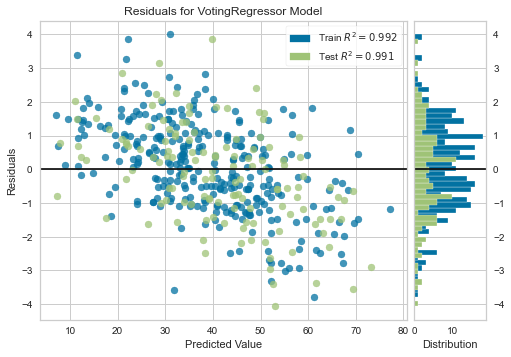

In [39]:
plot_model(final_blend)

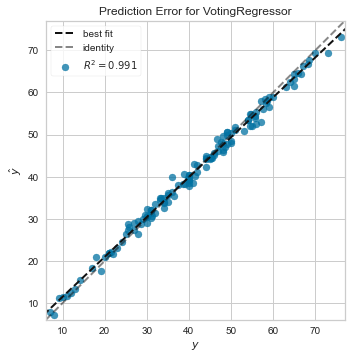

In [40]:
plot_model(final_blend, plot = 'error')

In [41]:
#https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6
plot_model(final_blend, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

 pid=68336) C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\resource_tracker.py:318: UserWarning: resource_tracker: There appear to be 100 leaked folder objects to clean up at shutdown
 pid=68336)   warnings.warn('resource_tracker: There appear to be %d '
 pid=68336) C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\resource_tracker.py:333: UserWarning: resource_tracker: C:\Users\mkumar\AppData\Local\Temp\joblib_memmapping_folder_68336_8f29f71da6954ced84959b05ca56096b_f58f9b78bae4431ea1c6dfdb42e2ac6c: FileNotFoundError(2, 'The system cannot find the path specified')
 pid=68336)   warnings.warn('resource_tracker: %s: %r' % (name, e))
 pid=68336) C:\Users\mkumar\AppData\Roaming\Python\Python38\site-packages\joblib\externals\loky\backend\resource_tracker.py:333: UserWarning: resource_tracker: C:\Users\mkumar\AppData\Local\Temp\joblib_memmapping_folder_68336_8f29f71da6954ced84959b05ca56096b_f8769613caf24f

## 6. Blind Test

In [44]:
skiprows = 0
dfblind = pd.read_excel("BlindTest_SSOIL.xlsx", sheet_name='Inputs', thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind.drop('307_Recovery factor (ultimate oil) (%)', axis=1, inplace=True)
dfblind.dropna(axis = 0, inplace=True)

dfblind.head(10)

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),149_Reservoir period,153_Depositional system (main),161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),EORIOR
0,FORMER SOVIET UNION,SIBERIAN WESTERN,119.000000,ONSHORE,138.00,3756,GAS DRIVE,8544.4,CRETACEOUS,24:COASTAL,LABYRINTH,0.590000,18.00,100.000000,40,1.00,580,490.00,4
1,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,214.157667,OFFSHORE,200.66,4670,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,19.00,47.000000,33,0.60,775,116.00,5
2,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,122.316975,OFFSHORE,199.94,4683,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,23.00,76.000000,29,0.80,707,129.00,5
3,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,563.399400,OFFSHORE,200.48,4534,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.379808,20.00,151.000000,34,0.30,1661,98.00,0
4,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,441.082425,OFFSHORE,205.52,6258,GAS DRIVE,3310.7,NEOGENE,21:FLUVIAL,LAYER-CAKE,0.760870,23.00,55.000000,30,0.86,683,47.00,1
5,ASIA-PACIFIC,SARAWAK,54.783857,OFFSHORE,202.30,4262,AQUIFER DRIVE,4322.8,NEOGENE,24:COASTAL,LAYER-CAKE,0.695000,35.40,47.430535,30,0.39,2500,10.70,3
6,ASIA-PACIFIC,SARAWAK,98.943076,OFFSHORE,202.30,4575,AQUIFER DRIVE,3023.2,NEOGENE,24:COASTAL,LAYER-CAKE,0.627000,41.08,55.040858,36,0.30,1500,16.53,3


In [45]:
BlindPredict1 = predict_model(final_blend, data=dfblind, round=2)

In [46]:
BlindPredict1 = BlindPredict1.rename(columns={'Label': 'Blended Predicted Recovery factor (ultimate oil) (%)'
                                 })

In [49]:
BlindPredict1

,10_Region,11_Basin name,52_Well spacing (average) (ac),72_Onshore or offshore,75_Temperature (original) (deg. F),77_Pressure (original) (psi),82_Drive mechanism (main),117_Reservoir top subsea depth (ft TVDSS),149_Reservoir period,153_Depositional system (main),161_Reservoir architecture (main),176_Net/gross ratio (average),204_Porosity (matrix average) (%),210_Permeability (air average) (mD),218_API gravity (average) (deg. API),225_Viscosity (oil average) (cp),252_GOR (initial average) (SCF/STB),293_Original in-place oil equivalent (MMBOE),EORIOR,Blended Predicted Recovery factor (ultimate oil) (%)
0,FORMER SOVIET UNION,SIBERIAN WESTERN,119.000000,ONSHORE,138.00,3756,GAS DRIVE,8544.4,CRETACEOUS,24:COASTAL,LABYRINTH,0.590000,18.00,100.000000,40,1.00,580,490.00,4,39.272728
1,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,214.157667,OFFSHORE,200.66,4670,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,19.00,47.000000,33,0.60,775,116.00,5,35.592698
2,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,122.316975,OFFSHORE,199.94,4683,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.520619,23.00,76.000000,29,0.80,707,129.00,5,42.649807
3,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,563.399400,OFFSHORE,200.48,4534,GAS DRIVE,2900.0,JURASSIC,21:FLUVIAL,LAYER-CAKE,0.379808,20.00,151.000000,34,0.30,1661,98.00,0,36.571793
4,LATIN AMERICA,GULF OF MEXICO NORTHERN OFFSHORE,441.082425,OFFSHORE,205.52,6258,GAS DRIVE,3310.7,NEOGENE,21:FLUVIAL,LAYER-CAKE,0.760870,23.00,55.000000,30,0.86,683,47.00,1,38.071930
5,ASIA-PACIFIC,SARAWAK,54.783857,OFFSHORE,202.30,4262,AQUIFER DRIVE,4322.8,NEOGENE,24:COASTAL,LAYER-CAKE,0.695000,35.40,47.430535,30,0.39,2500,10.70,3,37.980375
6,ASIA-PACIFIC,SARAWAK,98.943076,OFFSHORE,202.30,4575,AQUIFER DRIVE,3023.2,NEOGENE,24:COASTAL,LAYER-CAKE,0.627000,41.08,55.040858,36,0.30,1500,16.53,3,36.717645
